# Using a NiftyNet neural network model in PyTorch

## NiftyNet
<a href="https://niftynet.io/"><img src="https://niftynet.io/img/niftynet-logo.png" alt="drawing" width="150"/>

[NiftyNet](https://niftynet.io/) is "an open source convolutional neural networks platform for medical image analysis and image-guided therapy" built on top of [TensorFlow](https://www.tensorflow.org/). It is probably the easiest way to get started with deep learning for medical image and is mostly been used for segmentation.

*Image segmentation using deep learning* were the 5 most common words in all full paper titles from **both** [MICCAI 2018](https://www.miccai2018.org/en/) and [MIDL 2019](https://2019.midl.io/).

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">&quot;Image segmentation using deep learning&quot;, guess this is the hottest topic in MIDL <a href="https://twitter.com/hashtag/MIDL2019?src=hash&amp;ref_src=twsrc%5Etfw">#MIDL2019</a> <a href="https://twitter.com/midl_conference?ref_src=twsrc%5Etfw">@midl_conference</a> <a href="https://t.co/64smdMjnxY">pic.twitter.com/64smdMjnxY</a></p>&mdash; Hua Ma (@forever_pippo) <a href="https://twitter.com/forever_pippo/status/1148329951550197760?ref_src=twsrc%5Etfw">July 8, 2019</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Just like <a href="https://twitter.com/hashtag/miccai2018?src=hash&amp;ref_src=twsrc%5Etfw">#miccai2018</a>! <a href="https://t.co/3ZTHxj9iPT">pic.twitter.com/3ZTHxj9iPT</a></p>&mdash; Julia Schnabel (@ja_schnabel) <a href="https://twitter.com/ja_schnabel/status/1148356705916526592?ref_src=twsrc%5Etfw">July 8, 2019</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

This is probably due to the great success that convolutional neural networks (CNNs) have achieved in this field in the past years.

## HighRes3DNet

HighRes3DNet is a residual convolutional neural network designed to have a large receptive field and preserve a high resolution using a relatively small number of parameters. It was presented in 2017 by Li et al. at IPMI: [*On the Compactness, Efficiency, and Representation of 3D Convolutional Networks: Brain Parcellation as a Pretext Task*](https://arxiv.org/abs/1707.01992).

<img src="https://github.com/fepegar/tf2pt/raw/master/images/network.png" alt="drawing" width="600"/>

The authors used [NiftyNet](https://niftynet.io/) to train a model based on this architecture to perform [brain parcellation](https://ieeexplore.ieee.org/document/7086081?arnumber=7086081) from $T_1$-weighted MR images using the [ADNI dataset](http://adni.loni.usc.edu/).

This is an qualitative result the paper:

<img src="https://github.com/fepegar/tf2pt/raw/master/images/li-000.png" alt="drawing" width="150"/> <img src="https://github.com/fepegar/tf2pt/raw/master/images/li-001.png" alt="drawing" width="150"/>

The code of the architecture is on [NiftyNet's GitHub repository](https://github.com/NifTK/NiftyNet/blob/dev/niftynet/network/highres3dnet.py) and the authors have have uploaded thre parameters and configuration file to the [Model Zoo](https://github.com/NifTK/NiftyNetModelZoo/tree/5-reorganising-with-lfs/highres3dnet_brain_parcellation). After reading the paper and the code, it is relatively straightforward to implement the architecture using PyTorch.

In this notebook we will:

1. [Extract the parameters from a TensorFlow checkpoint](#TensorFlow-world)
2. [Transform them to PyTorch](#PyTorch-world)
3. [Apply the model to some test data](#Run-inference)



## Setup

### Install and import libraries

In [1]:
# %%capture
!pip install -r requirements.txt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import tempfile
from pathlib import Path
from configparser import ConfigParser

import numpy as np
import pandas as pd

import torch
from torchsummary import summary

from niftynet.io.image_reader import ImageReader
from niftynet.engine.sampler_grid_v2 import GridSampler
from niftynet.engine.windows_aggregator_grid import GridSamplesAggregator
from niftynet.layer.pad import PadLayer
from niftynet.layer.binary_masking import BinaryMaskingLayer
from niftynet.layer.histogram_normalisation import HistogramNormalisationLayer
from niftynet.layer.mean_variance_normalisation import MeanVarNormalisationLayer

from highresnet import HighRes3DNet

import tf2pt
import utils
import visualization

INFO:tensorflow:TensorFlow version 1.10.0
INFO:tensorflow:Available Image Loaders:
['nibabel', 'opencv', 'skimage', 'pillow', 'simpleitk', 'dummy'].


### Download NiftyNet data

We can use [NiftyNet's `net_download`](https://github.com/NifTK/NiftyNetModelZoo/tree/5-reorganising-with-lfs/highres3dnet_brain_parcellation#downloading-model-zoo-files) to get all we need from the [Model Zoo](https://github.com/NifTK/NiftyNetModelZoo/tree/5-reorganising-with-lfs):

In [3]:
try:
    import google.colab.data_table
except ModuleNotFoundError:
    print("We're not on Google Colab :(")

We're not on Google Colab :(


In [4]:
# %%capture
!net_download highres3dnet_brain_parcellation_model_zoo

Accessing: https://github.com/NifTK/NiftyNetModelZoo
highres3dnet_brain_parcellation_model_zoo: OK. 
Already downloaded. Use the -r option to download again.


In [5]:
niftynet_dir = Path('~/niftynet').expanduser()
utils.list_files(niftynet_dir)

niftynet/
    extensions/
        __init__.py
        network/
            __init__.py
        highres3dnet_brain_parcellation/
            __init__.py
            highres3dnet_config_eval.ini
    models/
        highres3dnet_brain_parcellation/
            settings_inference.txt
            Modality0.csv
            databrain_std_hist_models_otsu.txt
            inference_niftynet_log
            parcellation_output/
                window_seg_OAS1_0145_MR2_mpr_n4_anon_sbj_111__niftynet_out.nii.gz
                inferred.csv
            logs/
            models/
                model.ckpt-33000.meta
                model.ckpt-33000.data-00000-of-00001
                model.ckpt-33000.index
    data/
        OASIS/
            OAS1_0145_MR2_mpr_n4_anon_sbj_111.nii.gz
            license


There are three directories under `~/niftynet`:
1. `extensions` is a Python package and contains the [configuration file](https://niftynet.readthedocs.io/en/dev/config_spec.html)
2. `models` contains the landmarks for [histogram standardization](https://ieeexplore.ieee.org/document/836373) and the network parameters
3. `data` contains an [OASIS](https://www.oasis-brains.org/) MRI that can be used to test the model

In [45]:
models_dir = niftynet_dir / 'models'
zoo_entry = 'highres3dnet_brain_parcellation'
checkpoint_name = 'model.ckpt-33000'
checkpoint_path = models_dir / zoo_entry / 'models' / checkpoint_name
data_dir = niftynet_dir / 'data' / 'OASIS'
config_path = niftynet_dir / 'extensions' / zoo_entry / 'highres3dnet_config_eval.ini'
histogram_landmarks_path = models_dir / zoo_entry / 'databrain_std_hist_models_otsu.txt'
tempdir = Path(tempfile.gettempdir()) / 'miccai_niftynet_pytorch'
tempdir.mkdir(exist_ok=True)
csv_tf_path = tempdir / 'variables_tf.csv'
state_dict_tf_path = tempdir / 'state_dict_tf.pth'
state_dict_pt_path = tempdir / 'state_dict_pt.pth'
prediction_pt_dir = tempdir / 'prediction'
prediction_pt_dir.mkdir(exist_ok=True)

pd.set_option('display.max_colwidth', -1)  # do not truncate strings when displaying data frames
pd.set_option('display.max_rows', None)    # show all rows

Note that the path to the checkpoint is not a real filepath but the basename of the three checkpoint files.

## Transfer the parameters

### TensorFlow world 
<a href="https://www.tensorflow.org/"><img src="https://static.nvidiagrid.net/ngc/containers/tensorflow.png" alt="drawing" width="50"/>

Let's see what variables are stored in the checkpoint.

Some of them are filtered out by `tf2pt.checkpoint_to_state_dict()` for clarity:
* Variables used by the Adam optimizer during training
* Variables with no shape. They won't help much
* Variables containing `biased` or `ExponentialMovingAverage`. Results using these variables have turned out to be different to the ones produced by NiftyNet

We'll store the variables names in a data frame to list them in this notebook and the values in a Python dictionary to retrieve them later.

I figured out the code in `tf2pt.checkpoint_to_state_dict` reading the corresponding [TensorFlow docs](https://www.tensorflow.org/api_docs/python/tf/train/list_variables) and [Stack Overflow answers](https://stackoverflow.com/search?q=restore+tensorflow).

In [ ]:
tf2pt.checkpoint_to_state_dict(checkpoint_path, csv_tf_path, state_dict_tf_path)
data_frame_tf = pd.read_csv(csv_tf_path)
state_dict_tf = torch.load(state_dict_tf_path)
data_frame_tf

The layers names and parameters shapes overall seem to be coherent with the figure in the paper, but there's an additional $1 \times 1 \times 1$ convolutional layer with 80 output channels. It's also in the [code](https://github.com/NifTK/NiftyNet/blob/1832a516c909b67d0d9618acbd04a7642c12efca/niftynet/network/highres3dnet.py#L93). It seems to be the model with [dropout](http://jmlr.org/papers/v15/srivastava14a.html) used in the study to compute the model's uncertainty, so [our implementation of the architecture](https://github.com/fepegar/highresnet/blob/f434266a51924681f95b01a0f03611fbf1148db6/highresnet/highresnet.py#L82-L97) should include this layer as well.

There are three [dilation](https://arxiv.org/abs/1511.07122) blocks composed of three [residual](https://arxiv.org/abs/1512.03385) blocks each, which have two convolutional layers inside. That's $3 \times 3 \times 2 = 18$ layers. The other three layers are the initial convolution before the first residual block, the conv layer before the dropout and the classifier at the end. Apparently, *all* the convolutional layers have an associated [batch normalization]((https://arxiv.org/abs/1502.03167)) layer. That makes 21 convolutional layers and 21 batch normalization layers, all with parameters that must be transferred.

The shape of the weights of each conovolutional kernel represents the three spatial dimensions, the input channels and the output channels: $(D, H, W, C_{in}, C_{out})$

Each batch norm layer contains 4 parameter groups. Moving mean and variance of the batches, and the affine transformation parameters $\gamma$ (scale or *weight*) and $\beta$ (shift or *bias*):

\begin{align}
y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta
\end{align}

Therefore the total number of parameter groups is $21 + 21 \times 4 = 105$. The convolutional layers don't use a bias parameter, as it's not necessary when using batch norm.

### PyTorch world
<a href="https://pytorch.org/"><img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/01/pytorch-logo.png" alt="drawing" width="100"/>


In [ ]:
num_input_modalities = 1
num_classes = 160
model = HighRes3DNet(num_input_modalities, num_classes, add_dropout_layer=True)

Let's see what are the variable names created by PyTorch:

In [ ]:
state_dict_pt = model.state_dict()
rows = []
for name, parameters in state_dict_pt.items():
    if 'num_batches_tracked' in name:  # filter out for clarity
        continue
    shape = ', '.join(str(n) for n in parameters.shape)
    row = {'name': name, 'shape': shape}
    rows.append(row)
df_pt = pd.DataFrame.from_dict(rows)
df_pt

We can see that in Pytorch, `moving_mean` and `moving_variance` are `running_mean` and `running_var`. Also, $\gamma$ and $\beta$ are called `weight` and `bias`.

The convolutional kernels have a different arrangement: $(C_{out}, C_{in}, D, H, W)$.

The names and shapes look coherent and there are 105 lines in both lists, so we should be able to create a mapping between the TensorFlow and the PyTorch variables. The function `tf2pt` receives a TensorFlow-like variable and returns the corresponding PyTorch-like variable.

In [ ]:
for name_tf, tensor_tf in state_dict_tf.items():
    shape_tf = tuple(tensor_tf.shape)
    print(f'{str(shape_tf):18}', name_tf) 
    
    # Convert TensorFlow name to PyTorch name
    name_pt, tensor_pt = tf2pt.tf2pt(name_tf, tensor_tf)
    
    shape_pt = tuple(state_dict_pt[name_pt].shape)
    print(f'{str(shape_pt):18}', name_pt)
    
    # Sanity check
    if sum(shape_tf) != sum(shape_pt):
        raise ValueError
    
    state_dict_pt[name_pt] = tensor_pt
    print()
torch.save(state_dict_pt, state_dict_pt_path)
print('State dictionary saved to', state_dict_pt_path)

If PyTorch is happy when loading our state dict into the model, we should be on the right track 🤞...

In [ ]:
model.load_state_dict(state_dict_pt)

No incompatible keys. Yay! 🎉

### Plot weights

Something great about PyTorch is that the modules parameters are easily accesible. Let's plot some of them before and after training:

In [ ]:
model_pretrained = model
model_init = HighRes3DNet(num_input_modalities, num_classes, add_dropout_layer=True)

By [default](https://github.com/pytorch/pytorch/blob/77353636de32a207cf0a332395f91011bc2f07fb/torch/nn/modules/conv.py#L48-L53), convolutional layers in PyTorch are initialized using [He uniform variance scaling](https://arxiv.org/abs/1502.01852):

In [ ]:
visualization.plot_all_parameters(model_init)

And this is what they look like after training:

In [ ]:
visualization.plot_all_parameters(model_pretrained)

## Run inference

### Configuration file

We need to match the configuration used during training in order to obtain consistent results. This are the relevant contents of the downloaded [configuration file](https://niftynet.readthedocs.io/en/dev/config_spec.html):

```ini
[Modality0]
path_to_search = data/OASIS/
filename_contains = nii
pixdim = (1.0, 1.0, 1.0)
axcodes = (R, A, S)

[NETWORK]
name = highres3dnet
volume_padding_size = 10
whitening = True
normalisation = True
normalise_foreground_only=True
foreground_type = mean_plus
histogram_ref_file = databrain_std_hist_models_otsu.txt
cutoff = (0.001, 0.999)

[INFERENCE]
border = 2
spatial_window_size = (128, 128, 128)
```

In [ ]:
config = ConfigParser()
config.read(config_path);

### Reader

We can figure out the necessary preprocessing reading the paper, the [code](https://github.com/NifTK/NiftyNet/blob/61f2a8bbac1348591412c00f55d1c19b91c0367f/niftynet/application/segmentation_application.py#L95-L192) and the [configuration file](https://niftynet.readthedocs.io/en/dev/config_spec.html) that was downloaded. NiftyNet offers some powerful I/O tools. We will use readers, samplers and aggregators to read and write the necessary files. Some of the [demos](https://github.com/NifTK/NiftyNet/tree/dev/demos/module_examples) show how they can be used.

In [7]:
input_dict = dict(
    path_to_search=str(data_dir),
    filename_contains='nii',
    axcodes=('R', 'A', 'S'),
    pixdim=(1, 1, 1),
)
data_parameters = {
    'image': input_dict,
}
reader = ImageReader().initialise(data_parameters)

In [8]:
_, image_data_dict, _ = reader()
original_image = image_data_dict['image']
original_image.shape

(160, 256, 256, 1, 1)

Looking at the shape of our image and knowing it's now in [RAS+ orientation](http://www.grahamwideman.com/gw/brain/orientation/orientterms.htm), we can see that it represents $160$ sagittal slices of $256 \times 256$ pixels, with $1$ channel (monomodal) and $1$ time point. Let's see what it looks like:

In [40]:
from importlib import reload
reload(visualization)

<module 'visualization' from '/home/fernando/git/tf2pt/visualization.py'>

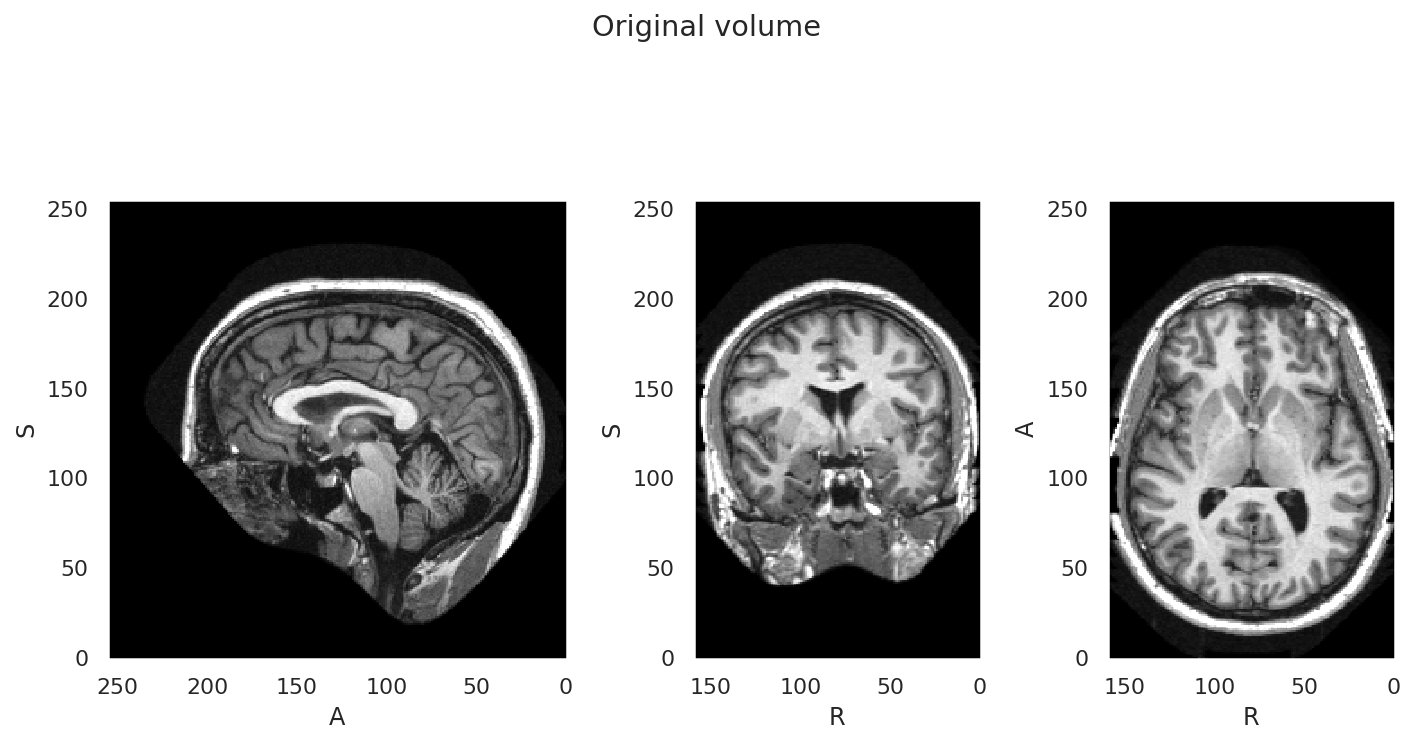

In [43]:
visualization.plot_volume(original_image, title='Original volume')

In [ ]:
visualization.plot_histogram(original_image, kde=False, labels=True, ylim=(0, 1e6))

### Preprocessing

We [pad the input volume](https://niftynet.readthedocs.io/en/dev/window_sizes.html#volume-padding-size) and crop the output volume to reduce the border effect introduced by the padded convolutions:

In [ ]:
volume_padding_layer = PadLayer(
    image_name=['image'],  # https://github.com/NifTK/NiftyNet/blob/61f2a8bbac1348591412c00f55d1c19b91c0367f/niftynet/layer/pad.py#L52
    border=(10, 10, 10),
)

We use a masking function in order to use only the foreground voxels for normalization:

In [ ]:
binary_masking_func = BinaryMaskingLayer(type_str=config['NETWORK']['foreground_type'])
mask = binary_masking_func(original_image)
visualization.plot_volume(mask, enhance=False, title='Binary mask for preprocessing')

We use [MRI histogram standardization](https://ieeexplore.ieee.org/document/836373) trained on the training dataset for our test image. We use the mean intensity of the volume as a threshold for the mask, as the authors claim that this usually gives good results.

In [ ]:
hist_norm = HistogramNormalisationLayer(
    image_name='image',
    modalities=['Modality0'],
    model_filename=str(histogram_landmarks_path),
    binary_masking_func=binary_masking_func,
    cutoff=(0.001, 0.999),
    name='hist_norm_layer',
)

Finally, we set our image foreground to have zero mean and unit variance:

In [ ]:
whitening = MeanVarNormalisationLayer(
    image_name='image', binary_masking_func=binary_masking_func)
preprocessing_layers = [
    volume_padding_layer,
    hist_norm,
    whitening,
]

Here's our preprocessed image:

In [ ]:
reader = ImageReader().initialise(data_parameters)
reader.add_preprocessing_layers(preprocessing_layers)
_, image_data_dict, _ = reader()
preprocessed_image = image_data_dict['image']
visualization.plot_volume(preprocessed_image, title='Preprocessed image')

We can clearly see the effect of the whitening layer on the histogram:

In [ ]:
visualization.plot_histogram(preprocessed_image, kde=False, ylim=(0, 1e6))

### Sampler and aggregator

As the whole image doesn't fit in most GPUs, we need to use a [patch-based](https://niftynet.readthedocs.io/en/dev/window_sizes.html) approach.

<img src="https://github.com/fepegar/tf2pt/raw/master/images/patch.png" alt="drawing" width="600"/>

We'll use NiftyNet's grid sampler to get all windows from the volume (blue in the previous image) and a grid samples aggregator (red) to reconstruct the output image from the inferred windows. If you have any memory issues, try reducing the window size.

The [window border](https://niftynet.readthedocs.io/en/dev/window_sizes.html#border) is needed to reduce the border effect in a dense prediction.

In [ ]:
window_size = 128
window_size = 3 * (window_size, )
window_border = 2, 2, 2
window_size_dict = {'image': window_size}
batch_size = 1

sampler = GridSampler(
    reader,
    window_size_dict,
    window_border=window_border,
)

aggregator = GridSamplesAggregator(
    image_reader=reader,
    window_border=window_border,
    output_path=prediction_pt_dir,
)

Now, the most important part: run the parcellation! We'll iterate over the windows provided by the sampler, pass them through the network and aggregate them in the output volume (this might take a couple of minutes):

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()
for batch_dict in sampler():
    input_tensor = tf2pt.niftynet_batch_to_torch_tensor(batch_dict).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
    labels = tf2pt.torch_logits_to_niftynet_labels(logits)
    window_dict = dict(window=labels)
    aggregator.decode_batch(window_dict, batch_dict['image_location'])

# Release GPU memory
del model
del model_pretrained
del input_tensor
del logits
torch.cuda.empty_cache()

Let's [run the inference using NiftyNet](https://github.com/NifTK/NiftyNetModelZoo/tree/5-reorganising-with-lfs/highres3dnet_brain_parcellation#generating-segmentations-for-example-data) as well, so that we can compare both results:

In [ ]:
# %%capture
!net_segment inference -c ~/niftynet/extensions/highres3dnet_brain_parcellation/highres3dnet_config_eval.ini

## Check results

In [46]:
input_image = utils.get_first_array(data_dir)
labels_nn = utils.get_first_array(models_dir).astype(np.uint16)
labels_pt = utils.get_first_array(prediction_pt_dir).astype(np.uint16)

### Quantitatively

In [47]:
difference = labels_nn != labels_pt
np.count_nonzero(difference)

0

Success! ✨ Both parcellations are exactly the same.

### Qualitatively

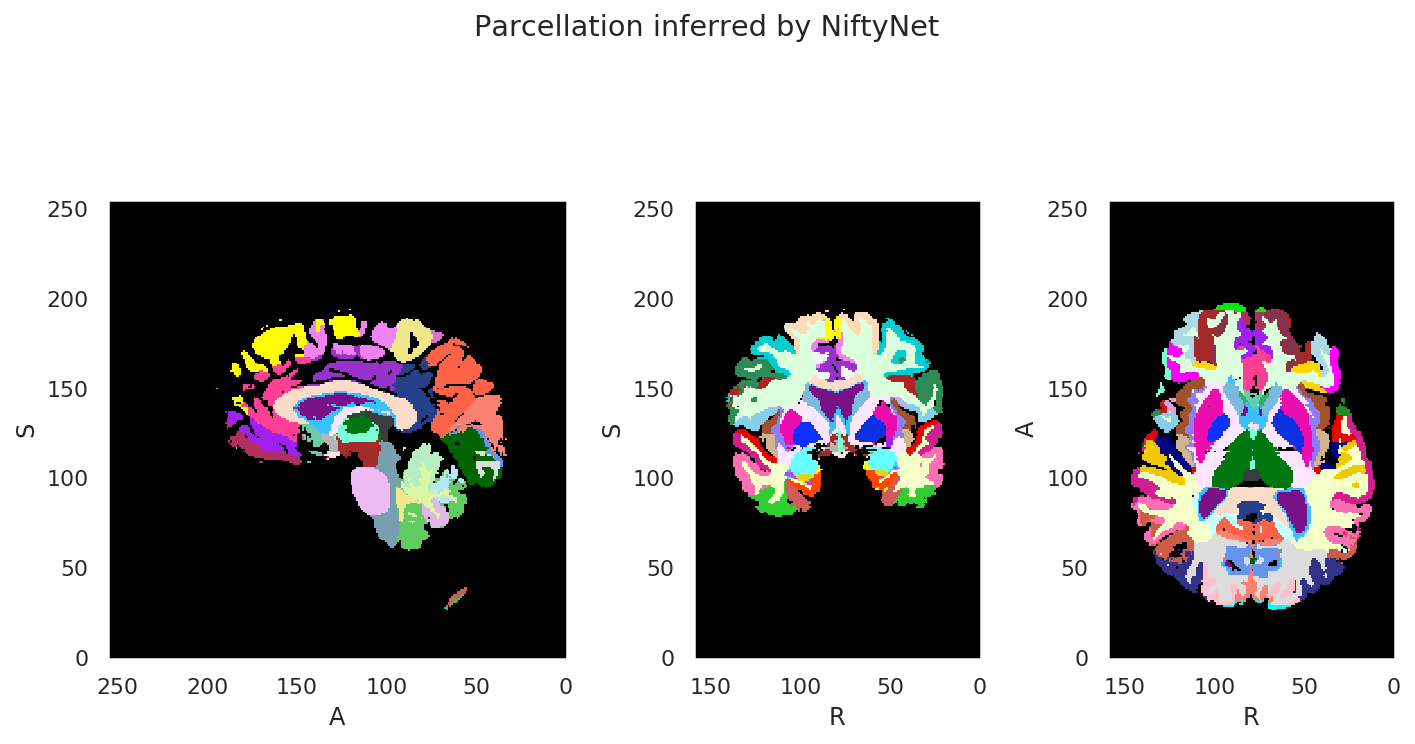

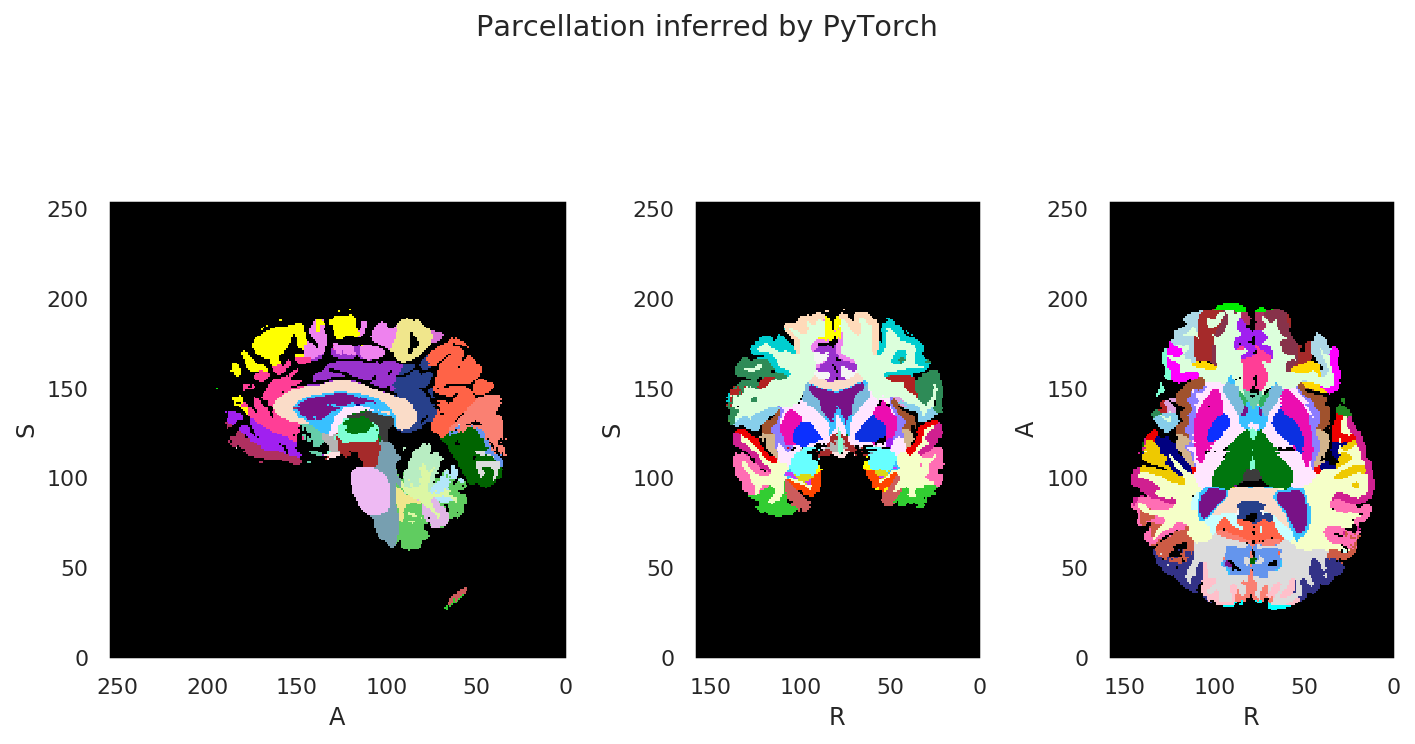

In [48]:
colors_path = 'GIFNiftyNet.ctbl'
visualization.plot_volume(
    labels_nn,
    enhance=False,
    colors_path=colors_path,
    title='Parcellation inferred by NiftyNet',
)
visualization.plot_volume(
    labels_pt,
    enhance=False,
    colors_path=colors_path,
    title='Parcellation inferred by PyTorch',
)

## Conclusion

## Reproducibility

### Running this notebook

To write this notebook I have used Ubuntu 18.04 installed on an Alienware 13 R3 laptop, which includes a 6 GB GeForce GTX 1060 NVIDIA GPU. I'm using CUDA 9.0.

Inference using PyTorch took 5725 MB of GPU memory. TensorFlow usually takes as much as possible beforehand.

To run this notebook locally, I recommend downloading the repository and creating a [`conda`](https://docs.conda.io/en/latest/miniconda.html) environment:

```shell
$ git clone https://github.com/fepegar/miccai-educational-challenge-2019.git
$ cd miccai-educational-challenge-2019
$ conda create -n emiccai python=3.6 -y
$ conda activate emiccai && conda install jupyterlab -y && jupyter lab
```

* Zenodo
* conda
* figshare
* google colab
* github
* Docker